<a href="https://colab.research.google.com/github/aqhareus/floorplan-stable-diffusion-AI54/blob/main/floor_plan_sd_lora.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Workshop: Fine-Tuning Stable Diffusion for Semantic Segmentation**
**Course: AI54 | Dr. Mohamed Kas**

**Objective:**
In this workshop, we will explore "Domain Adaptation." We will take a model trained on natural photos (Stable Diffusion 1.5) and force it to learn a technical task: generating **Semantic Segmentation Maps**.

**Pipeline:**
1.  **Baseline Test:** Prove SD1.5 cannot do this natively.
2.  **Data Prep:** Download and filter the ADE20K dataset for indoor scenes.
3.  **Training:** Fine-tune the model using LoRA (Low-Rank Adaptation).
4.  **Inference:** Test the new weights.

In [ ]:
# @title 1. Install Dependencies
# We install diffusers, accelerate, and wandb for tracking.
!pip install -q diffusers transformers accelerate bitsandbytes wandb datasets==3.6.0
!pip install -q -U xformers  # Memory efficient attention

import torch
import os
from google.colab import output

print(f"PyTorch Version: {torch.__version__}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
else:
    print("WARNING: No GPU detected. Go to Runtime > Change runtime type > T4 GPU")

output.clear()
print("Dependencies installed successfully.")

Dependencies installed successfully.


In [ ]:
# @title 2. Login to Services
from huggingface_hub import notebook_login
import wandb

print("--- Hugging Face Login ---")
print("You need a read-access token from https://huggingface.co/settings/tokens")
notebook_login()

print("\n--- Weights & Biases Login ---")
print("You need an API key from https://wandb.ai/authorize")
wandb.login()

--- Hugging Face Login ---
You need a read-access token from https://huggingface.co/settings/tokens



--- Weights & Biases Login ---
You need an API key from https://wandb.ai/authorize


/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)
wandb: (1) Create a W&B account
wandb: (2) Use an existing W&B account
wandb: (3) Don't visualize my results
wandb: Enter your choice:

 2


wandb: You chose 'Use an existing W&B account'
wandb: Logging into https://api.wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: Find your API key here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: sofea-utbm (sofeasuhaimi-utbm) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

## **Phase 1: Baseline Failure Analysis**
We first ask the standard model to generate a segmentation map. It will likely fail, generating a photo of a room or an artistic drawing instead of a class mask.

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model_index.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/617 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

text_encoder/model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

scheduler_config.json:   0%|          | 0.00/308 [00:00<?, ?B/s]

safety_checker/model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

config.json: 0.00B [00:00, ?B/s]

tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

unet/diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

vae/diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/547 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`torch_dtype` is deprecated! Use `dtype` instead!


Generating baseline image...


  0%|          | 0/50 [00:00<?, ?it/s]

Baseline Result (Expected Failure):


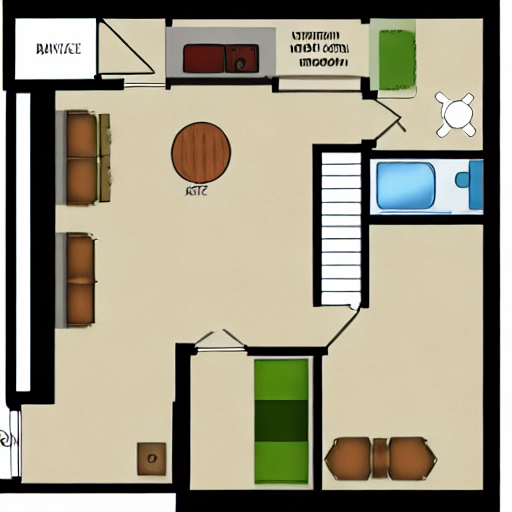

In [ ]:
# @title Run Baseline Inference
import torch
from diffusers import StableDiffusionPipeline
from PIL import Image

# 1. Load SD1.5
model_id = "runwayml/stable-diffusion-v1-5"
pipe = StableDiffusionPipeline.from_pretrained(model_id, torch_dtype=torch.float16)
pipe = pipe.to("cuda")

# 2. Prompt for a mask
# prompt = "semantic segmentation map of a living room with sofa, lamp, and window"
prompt = "colored floor plan drawing of an apartment with rooms and corridors"

# 3. Generate
print("Generating baseline image...")
image = pipe(prompt).images[0]
image.save("baseline_floorplan.png")

# 4. Display
print("Baseline Result (Expected Failure):")
display(image)

# 5. Clean up memory for training
del pipe
torch.cuda.empty_cache()

## **Phase 2: Dataset Preparation**
We will create a script `prepare_data.py` to download the **ADE20K** dataset.
* It filters for images containing at least **5 indoor furniture items** (rich scenes).
* It converts the integer masks to RGB images.
* It creates a `metadata.jsonl` file where the text prompt lists every object in the scene.

In [ ]:
%%writefile prepare_data.py
import os
import json
from datasets import load_dataset

# We will use the "colors" images + "captions"
# and save them in: floorplans/images + floorplans/metadata.jsonl

BASE_DIR = "floorplans"
IMG_DIR = os.path.join(BASE_DIR, "images")
META_PATH = os.path.join(BASE_DIR, "metadata.jsonl")

os.makedirs(IMG_DIR, exist_ok=True)

def main():
    print("Loading pseudo-floor-plan-12k dataset...")
    ds = load_dataset("zimhe/pseudo-floor-plan-12k", split="train")

    count = 0
    with open(META_PATH, "w", encoding="utf-8") as f:
        for i, sample in enumerate(ds):
            # Choose which view to train on:
            #   sample["plans"], sample["walls"], sample["colors"], sample["footprints"]
            img = sample["colors"]     # <--- segmentation-style colored floorplan
            caption = sample["captions"]

            filename = f"img_{i:05d}.png"
            out_path = os.path.join(IMG_DIR, filename)
            img.save(out_path)

            record = {
                "file_name": f"images/{filename}",
                "text": caption
            }
            f.write(json.dumps(record) + "\n")
            count += 1

            if count % 500 == 0:
                print(f"Saved {count} samples...")

    print(f"✅ Done. Saved {count} samples.")
    print(f"Images dir : {IMG_DIR}")
    print(f"Metadata   : {META_PATH}")

if __name__ == "__main__":
    main()


Writing prepare_data.py


In [ ]:
# @title Create Data Script
%%writefile prepare_data.py
import os
import json
import numpy as np
from datasets import load_dataset
from PIL import Image
from tqdm import tqdm

# --- CONFIGURATION ---
BASE_DIR = "segmentation"
MASKS_DIR = os.path.join(BASE_DIR, "masks")
JSON_PATH = os.path.join(BASE_DIR, "metadata.jsonl")
TARGET_SAMPLES = 1000

# Strict Filter: Image must contain > 4 of these specific objects
REQUIRED_INDOOR_OBJECTS = {
    "bed", "sofa", "armchair", "coffee table", "wardrobe", "bookcase",
    "refrigerator", "stove", "microwave", "kitchen island", "countertop",
    "dishwasher", "oven", "bathtub", "toilet", "sink", "screen",
    "monitor", "television", "desk", "table", "lamp", "shower"
}

# ADE20K Classes (Full list)
ADE20K_CLASSES = [
    "wall", "building", "sky", "floor", "tree", "ceiling", "road", "bed", "windowpane", "grass",
    "cabinet", "sidewalk", "person", "earth", "door", "table", "mountain", "plant", "curtain", "chair",
    "car", "water", "painting", "sofa", "shelf", "house", "sea", "mirror", "rug", "field", "armchair",
    "seat", "fence", "desk", "rock", "wardrobe", "lamp", "bathtub", "railing", "cushion", "base", "box",
    "column", "signboard", "chest", "counter", "sand", "sink", "skyscraper", "fireplace", "refrigerator",
    "grandstand", "path", "stairs", "runway", "case", "pool", "pillow", "screen", "stairway", "river",
    "bridge", "bookcase", "blind", "coffee table", "toilet", "flower", "book", "hill", "bench", "countertop",
    "stove", "palm", "kitchen island", "computer", "swivel chair", "boat", "bar", "arcade", "hovel", "bus",
    "towel", "light", "truck", "tower", "chandelier", "awning", "streetlight", "booth", "television",
    "airplane", "dirt", "apparel", "pole", "land", "bannister", "escalator", "ottoman", "bottle", "buffet",
    "poster", "stage", "van", "ship", "fountain", "conveyer belt", "canopy", "washer", "plaything",
    "swimming pool", "stool", "barrel", "basket", "waterfall", "tent", "bag", "minibike", "cradle", "oven",
    "ball", "food", "step", "tank", "trade name", "microwave", "pot", "animal", "bicycle", "lake",
    "dishwasher", "screen", "blanket", "sculpture", "hood", "sconce", "vase", "traffic light", "tray",
    "ashcan", "fan", "pier", "crt screen", "plate", "monitor", "bulletin board", "shower", "radiator",
    "glass", "clock", "flag"
]

def get_ade20k_palette():
    np.random.seed(42)
    palette = np.random.randint(0, 255, size=(151, 3), dtype=np.uint8)
    palette[0] = [0, 0, 0]
    return palette

def index_to_rgb(mask_array, palette):
    mask_array = np.clip(mask_array, 0, 150)
    return palette[mask_array]

def get_objects_in_mask(mask_array):
    unique_ids = np.unique(mask_array)
    found = set()
    for uid in unique_ids:
        if 0 <= uid < len(ADE20K_CLASSES):
            found.add(ADE20K_CLASSES[uid])
    return found

if __name__ == "__main__":
    if not os.path.exists(MASKS_DIR):
        os.makedirs(MASKS_DIR)
    palette = get_ade20k_palette()

    print("--- DOWNLOADING & FILTERING DATASET ---")
    dataset = load_dataset("scene_parse_150", split="train", trust_remote_code=True)

    count = 0
    pbar = tqdm(total=TARGET_SAMPLES, desc="Processing Rich Scenes")

    with open(JSON_PATH, "w") as f:
        for sample in dataset:
            if count >= TARGET_SAMPLES: break

            mask_img = sample["annotation"]
            mask_array = np.array(mask_img)
            present_objects = get_objects_in_mask(mask_array)

            match_count = len(present_objects.intersection(REQUIRED_INDOOR_OBJECTS))
            if match_count <= 4: continue

            all_objs = sorted(list(present_objects))
            if not all_objs: continue
            obj_str = ", ".join(all_objs)
            prompt = f"semantic segmentation map of a living room with {obj_str}"

            rgb_mask = Image.fromarray(index_to_rgb(mask_array, palette))
            filename = f"mask_{count:05d}.png"
            rgb_mask.save(os.path.join(MASKS_DIR, filename))

            entry = {"file_name": os.path.join("masks", filename), "text": prompt}
            f.write(json.dumps(entry) + "\n")

            count += 1
            pbar.update(1)

Overwriting prepare_data.py


In [ ]:
# @title Run Dataset Generation
!python prepare_data.py

Loading pseudo-floor-plan-12k dataset...
README.md: 1.40kB [00:00, 3.03MB/s]
data/train-00000-of-00008.parquet: 100% 491M/491M [00:10<00:00, 45.2MB/s]
data/train-00001-of-00008.parquet: 100% 491M/491M [00:16<00:00, 29.7MB/s]
data/train-00002-of-00008.parquet: 100% 490M/490M [00:09<00:00, 50.9MB/s]
data/train-00003-of-00008.parquet: 100% 490M/490M [00:18<00:00, 26.7MB/s]
data/train-00004-of-00008.parquet: 100% 491M/491M [00:09<00:00, 49.1MB/s]
data/train-00005-of-00008.parquet: 100% 491M/491M [00:10<00:00, 47.7MB/s]
data/train-00006-of-00008.parquet: 100% 490M/490M [00:20<00:00, 24.4MB/s]
data/train-00007-of-00008.parquet: 100% 490M/490M [00:03<00:00, 128MB/s]
Generating train split: 100% 12000/12000 [02:17<00:00, 87.20 examples/s]
Saved 500 samples...
Saved 1000 samples...
Saved 1500 samples...
Saved 2000 samples...
Saved 2500 samples...
Saved 3000 samples...
Saved 3500 samples...
Saved 4000 samples...
Saved 4500 samples...
Saved 5000 samples...
Saved 5500 samples...
Saved 6000 samples

## **Phase 3: LoRA Training**
We now use the official Hugging Face training script.
* **Max Steps:** 2000
* **Validation:** Every 500 steps.
* **Logging:** Check your WandB dashboard to see the loss curve and validation images appearing in real-time.

In [ ]:
# @title Download & Run Training Script
# 1. Download Script
!wget -q https://raw.githubusercontent.com/huggingface/diffusers/v0.35.2/examples/text_to_image/train_text_to_image_lora.py

import os

# 2. Set Env Variables
os.environ["MODEL_NAME"] = "runwayml/stable-diffusion-v1-5"
os.environ["TRAIN_DIR"] = "floorplans"
os.environ["OUTPUT_DIR"] = "sd-floorplan-colors-lora"

# 3. Launch Training
# Note: Two validation prompts are used to test generalization
!accelerate launch train_text_to_image_lora.py \
  --pretrained_model_name_or_path=$MODEL_NAME \
  --train_data_dir=$TRAIN_DIR \
  --resolution=512 \
  --train_batch_size=1 \
  --gradient_accumulation_steps=4 \
  --max_train_steps=2000 \
  --learning_rate=1e-04 \
  --max_grad_norm=1 \
  --lr_scheduler="cosine" \
  --lr_warmup_steps=0 \
  --output_dir=$OUTPUT_DIR \
  --mixed_precision="fp16" \
  --seed=42 \
  --report_to="wandb" \
  --validation_prompt="colored floor plan drawing of an apartment with several rooms" \
  --checkpointing_steps=500\
  --checkpoints_total_limit=2\
  --rank=64

The following values were not passed to `accelerate launch` and had defaults used instead:
	`--num_processes` was set to a value of `1`
	`--num_machines` was set to a value of `1`
	`--mixed_precision` was set to a value of `'no'`
	`--dynamo_backend` was set to a value of `'no'`
To avoid this warning pass in values for each of the problematic parameters or run `accelerate config`.
2025-12-10 23:42:46.161388: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1765410166.487778    8471 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1765410166.572125    8471 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1765410167.196924    8471 computation_plac

## **Phase 4: Final Inference**
Now we load our trained LoRA adapter and test it with a prompt containing many objects.

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

No LoRA keys associated to CLIPTextModel found with the prefix='text_encoder'. This is safe to ignore if LoRA state dict didn't originally have any CLIPTextModel related params. You can also try specifying `prefix=None` to resolve the warning. Otherwise, open an issue if you think it's unexpected: https://github.com/huggingface/diffusers/issues/new


  0%|          | 0/30 [00:00<?, ?it/s]

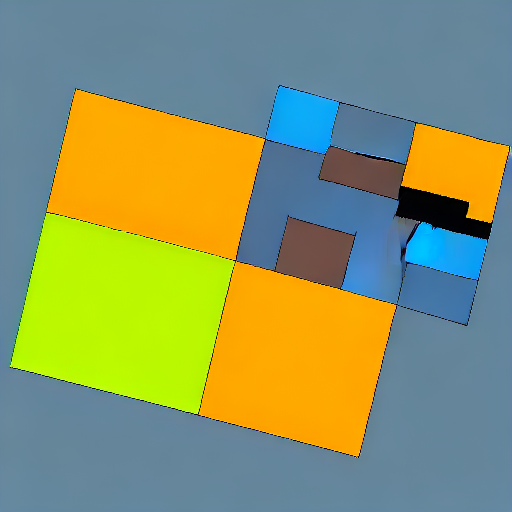

Saved lora_floorplan_result.png
Check the image above. It should look like a flat color map, not a photo.


In [ ]:
from diffusers import StableDiffusionPipeline
import torch
from IPython.display import display

pipe = StableDiffusionPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5",
    torch_dtype=torch.float16
).to("cuda")

pipe.load_lora_weights("sd-floorplan-colors-lora")

prompt = "colored floor plan drawing of a two-bedroom apartment and one kitchen"

image = pipe(prompt, num_inference_steps=30).images[0]
image.save("lora_floorplan_result.png")
display(image)

print("Saved lora_floorplan_result.png")
print("Check the image above. It should look like a flat color map, not a photo.")
